# The MNIST data

Images of handwritten digits: ![Alt][1]
[1]: https://www.tensorflow.org/versions/r0.10/images/MNIST.png

* For each image we have a label telling us which digit it is
* The MNIST data is hosted on [Yann LeCun's website](http://yann.lecun.com/exdb/mnist/) 

In [163]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [164]:
print mnist.train.images.shape

(55000, 784)


The MNIST data is split into three parts: 
* **mnist.train** : 55,000 data points of training set 
* **mnist.test** : 10,000 data points of test set 
* **mnist.validation** : 5,000 data points of validation set

Every MNIST data point has two parts: 
* an image of a handwritten digit (called "x")
* a corresponding label (called "y").

Both the training set and test set contain images and their corresponding labels

Each image is 28 pixels by 28 pixels (array of numbers)

![Alt][1]
[1]:  https://www.tensorflow.org/versions/r0.10/images/MNIST-Matrix.png

* The array can be flattened into a vector of 28x28 = 784 numbers
* Flattening ignores the 2D spatial structure of the images
* The dataset becomes a point cloud into the 784-dimensional space

### Structure of the images tensor

* mnist.train.images is a tensor (an n-dimensional array) with a shape of [55000, 784]
* The first dimension is an index into the list of images 
* The second dimension is the index for each pixel in each image
* Each entry in the tensor is a pixel intensity between 0 and 1

![Alt][1]
[1]: https://www.tensorflow.org/versions/r0.10/images/mnist-train-xs.png

### Structure of the labels tensor

The label is a number between 0 and 9 representing the digit drawn in the image.

* The labels are represented as "*one-hot vectors*". A one-hot vector is a vector which is 0 in most dimensions, and 1 in a single dimension. In this case, the n-th digit will be represented as a vector which is 1 in the n-th dimensions. For example, 3 would be
\[
0
0
0
1
0
0
0
0
0
0\]
. 

* The mnist.train.labels is a [55000, 10] array of floats.

![Alt][1]
[1]: https://www.tensorflow.org/versions/r0.10/images/mnist-train-ys.png

# Softmax Regression: theory

* There are only 10 possible classes 
* We want to estimate the probabilities for the image being each digit class

Softmax regression fits naturally here
* Collect evidence that an data sample falls into a class
* Convert this evidence into a probability

Evidence that a given image is in a particular class: weighted sum of the pixel intensities. 

The weight is:
- negative if that pixel having a high intensity is evidence against the image being in that class, 
- positive if it is evidence in favor.

We also add some extra evidence called a *bias* (to be able to say that some things are more likely independent of the input).

The **evidence** for a class i given an input x is:

\begin{equation}
{\rm evidence} = \sum_j W_{ij} x_j + b_i
\end{equation}

where:
- $W_i$ and $b_i$ is the weight and bias resp. for the i-th digit class.

- $j$ is an index for summing over the pixels in our input image $x$.

We then convert the evidence sums into our predicted probabilities $y$ using the **softmax** function:

\begin{equation}
y = {\rm softmax} ({\rm evidence})
\end{equation}

\begin{equation}
{\rm softmax}(x)_i = \frac{\exp(x_i)}{\sum_j \exp(x_j)}
\end{equation}

It results a valid probability distribution.

For each output, we compute a weighted sum of the $x$s, add a bias, and then apply softmax.

![Alt][1]

[1]: https://www.tensorflow.org/versions/r0.10/images/softmax-regression-scalargraph.png



In form of equations:

![Alt][1]

[1]: https://www.tensorflow.org/versions/r0.10/images/softmax-regression-scalarequation.png

Vectorizing this:

![Alt][1]
[1]: https://www.tensorflow.org/versions/r0.10/images/softmax-regression-vectorequation.png

In compact form:

\begin{equation}
y = {\rm softmax}(W x + b)
\end{equation}

# Softmax Regression: implementation

In [165]:
import tensorflow as tf

Create a symbolic variable

In [166]:
x = tf.placeholder(tf.float32, [None, 784])

* $x$ is a placeholder, a value that we'll input when we ask TensorFlow to run a computation 
* We want to be able to input *any number of* MNIST images, each flattened into a 784-dimensional vector
* The input tensor $x$ is represented as a 2-D tensor of floating-point numbers, with a shape [None, 784]. 
* *None* means that a dimension can be of any length

We also need the weights and biases for our model

In [167]:
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

* Variables are modifiable tensors
* **Model parameters in ML are typically defined as variables**
* Here they are initialized to zeros

Notice that:
- W has a shape of [784, 10] because we want to multiply the 784-dimensional image vectors by it to produce 10-dimensional vectors of evidence for the difference classes. 
- b has a shape of [10] so we can add it to the output.

We are ready to define our model. It only takes one line to define it!

In [168]:
y = tf.nn.softmax(tf.matmul(x, W) + b)

# Training

**Loss**: represents how far off our model is from our desired outcome

Loss function we will use: **cross-entropy**

The cross-entropy is measuring how inefficient our predictions are for describing the true labels.

\begin{equation}
H(y) =  - \sum_i y^\prime_i \log(y_i)
\end{equation}

where:
* $y$: predicted labels
* $y^\prime$: true labels

More information about cross-entropy can be found [here](http://colah.github.io/posts/2015-09-Visual-Information/).

We need a placeholder to input the correct answers.

In [169]:
y_ = tf.placeholder(tf.float32, [None, 10])

In [170]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

* tf.log(y) computes the logarithm of each element of y. 
* Next, each element of y_ is multiplied with the corresponding element of tf.log(y). 
* Then tf.reduce_sum adds the elements in the second dimension of y, due to the reduction_indices=[1] parameter. 
* Finally, tf.reduce_mean computes the mean over all the examples in the batch.

We are ready to set the optimizer

- TensorFlow knows the whole graph of computations
- It can use the [Backpropagation algorithm](http://colah.github.io/posts/2015-08-Backprop/) to compute how the loss is affected by each variable

In [171]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

* We ask TensorFlow to minimize cross_entropy using the gradient descent algorithm with a learning rate of 0.5.
* Gradient descent simply shifts each variable a little bit in the direction that reduces the loss
* Many other [optimizers](https://www.tensorflow.org/versions/r0.10/api_docs/python/train.html#optimizers) are available in TensorFlow
* TensorFlow (behind the scenes) adds new operations to the graph which implement backpropagation and gradient descent.

In [172]:
init = tf.initialize_all_variables()

In [173]:
sess = tf.Session()
sess.run(init)

Run the training step 1000 times

In [174]:
for i in range(1000):
  batch_xs, batch_ys = mnist.train.next_batch(100)
  sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

* Each step of the loop, we get a "batch" of one hundred random data points from our training set
* Using small batches of random data is called *stochastic training*

# Evaluation

In [175]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

* tf.argmax() gives you the index of the highest entry in a tensor along some axis
* tf.equal() gives us a list of booleans. 
* To determine what fraction are correct, we cast to floating point numbers and then take the mean

In [176]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Finally, we want to compute the accuracy on our test data.

In [177]:
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9196


# Exercise 1 : Visualize the weight matrices for each class

(784, 10)


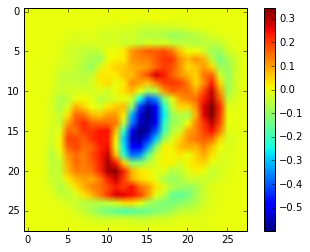

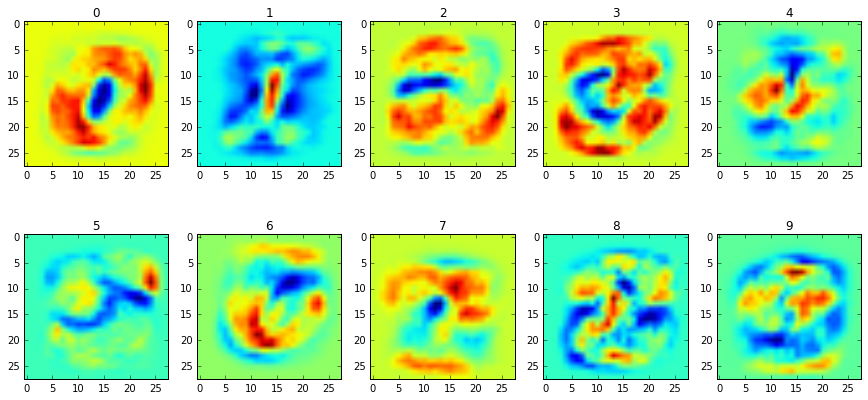

In [178]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

W_array = sess.run(W)
print W_array.shape

img = W_array[:, 0].reshape(28, 28)
imgplot = plt.imshow(img)
plt.colorbar()

f, axarr = plt.subplots(2, 5, figsize=(15, 7))
for i in range(0, 2):
    for j in range(0, 5):
        digit_class = i * 5 + j
        axarr[i, j].imshow(W_array[:, digit_class].reshape(28,28))
        axarr[i, j].set_title(str(digit_class))


# Exercise 2 : Convergence plots.

In [135]:
sess.close()
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

loss_array = []
eval_loss_array = []
for i in range(1000):
  batch_xs, batch_ys = mnist.train.next_batch(100)
  _, current_loss = sess.run([train_step, cross_entropy], feed_dict={x: batch_xs, y_: batch_ys})
  loss_array.append(current_loss)
  current_eval_loss = sess.run([cross_entropy], feed_dict={x: mnist.test.images, y_: mnist.test.labels})
  eval_loss_array.append(current_eval_loss)  

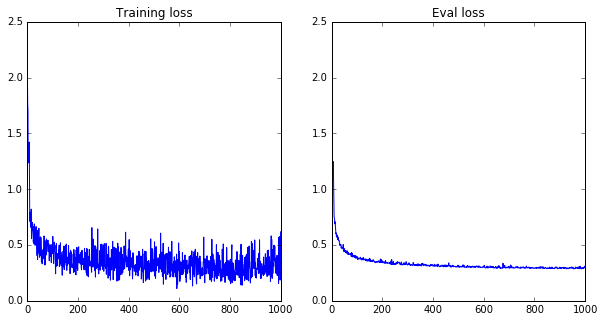

In [148]:
f, axarr = plt.subplots(1, 2,  figsize=(10, 5))
axarr[0].plot(loss_array)
axarr[0].set_title('Training loss')

axarr[1].plot(eval_loss_array)
axarr[1].set_title('Eval loss')